### Def

In [4]:
%run '../definitions.ipynb'

In [5]:
import os
import pandas as pd
from tqdm import tqdm
import zipfile
import zlib
import os
import gc

class XAMSRaw():
    '''
    New in version 1: just one channel, separate array for waveforms
    New in version 2: first process, then read all
    '''
    __version__ = '2.1.0'
    base_dir = ''
    filenames = []
    # d: dataframe for properties
    df = None
    # d: array for data.
    d = None
    channel = -1
    
    ###################### Initialization and data loading
    def __init__(self, data_dir, run_name, channel, pickle_dir = '/home/erik/win/data/xams_run8/single_e_waveforms/'):
        self.run_name = run_name
        self.base_dir = os.path.join(data_dir, run_name)
        self.pickle_dir = os.path.join(pickle_dir, run_name)
        self.filenames = os.listdir(self.base_dir)
        self.filenames = [_f for _f in self.filenames if _f[-4:] == '.zip']
        self.channel = channel
        self.d = np.array([])
        self.df = pd.DataFrame()
        
        if not os.path.exists(self.pickle_dir):
            print('Making new pickle directory')
            os.makedirs(self.pickle_dir)
        return
                     
    def process_all(self, stop_after, baseline_left, baseline_right, area_bounds, gain, force_reload = False):
        for filename in tqdm(self.filenames[:stop_after]):
            file_path = os.path.join(self.base_dir, filename)
            # Get filename and full path to pickle
            pickle_filename = filename.replace('.zip', '_waveforms_ch%d.pickle' % (self.channel))
            processed_filename = filename.replace('.zip', '_processed_ch%d.pickle' % (self.channel))
            pickle_path = os.path.join(self.pickle_dir, pickle_filename)
            processed_pickle_path = os.path.join(self.pickle_dir, processed_filename)
            
            if os.path.isfile(processed_pickle_path) and not force_reload:
                # We already have this processed data!
                continue
            
            # Read raw data
            # Check if we have a correspoding pickle file
            if os.path.isfile(pickle_path):
                _pulse_list = pickle.load(open(pickle_path, 'rb'))
            else:
                _pulse_list = self._read_pulses_in_file(file_path, self.channel)
            
            if not os.path.isfile(pickle_path):
                pickle.dump(_pulse_list, open(pickle_path, 'wb'))
            
            self.d = np.array(_pulse_list, dtype=float)
            
            # Now process
            self.process(baseline_left, baseline_right, area_bounds, gain)
            pickle.dump(self.df, open(processed_pickle_path, 'wb'))
        # Remove the remaining data in self
        self.d = None
        self.df = None
        return
    
    def load_processed(self, stop_after):
        df_list = []
        for filename in tqdm(self.filenames[:stop_after]):
            file_path = os.path.join(self.base_dir, filename)
            # Get filename and full path to pickle
            processed_filename = filename.replace('.zip', '_processed_ch%d.pickle' % (self.channel))
            processed_pickle_path = os.path.join(self.pickle_dir, processed_filename)
            try:
                df_list.append(
                    pickle.load(open(processed_pickle_path, 'rb'))
                    )
            except:
                raise ValueError('Error reading %s' % processed_pickle_path)
        self.df = pd.concat(df_list)
        self.df['event_number'] = np.arange(0, len(self.df))
        self.df['dataset_number'] = np.concatenate([np.ones(1000, dtype=int) * i 
                                                    for i in range(len(self.filenames[:stop_after]))])
    def load_waveforms(self):
        '''
        Load the waveform data but only for events that are in the dataframe after cuts.
        Assumes that pickle files are already built.
        '''
        d_list = []
        dataset_numbers = np.unique(self.df['dataset_number'])
        
        # Loop over datasets and the dataframe grouped by dataset index
        for index, grouped_df in tqdm(self.df.groupby('dataset_number')):
            events_this_df = grouped_df['event_number'].values
            # These are the selected events
            min_event = index * 1000
            max_event = (index + 1) * 1000
            sel = np.array([i in events_this_df for i in np.arange(min_event, max_event)])
            
            # Where is the file?
            filename = self.filenames[index]
            file_path = os.path.join(self.base_dir, filename)
            pickle_filename = filename.replace('.zip', '_waveforms_ch%d.pickle' % (self.channel))
            pickle_path = os.path.join(self.pickle_dir, pickle_filename)
            # Load data
            d = np.array(pickle.load(open(pickle_path, 'rb')), dtype=float)
            d = d[sel]
            d_list.append(d)
        self.d = np.concatenate(d_list)
        return
            
    ###################### Basic processing
    # All `compute_` functions add one or more variable to the dataframe
    # All `correct_` functions will change the waveform (and also the `invert` one, incidentally)    
    def compute_baselines(self, baseline_bounds = (0, 300), mode='average'):
        '''
        Compute the baseline by using the waveform within a certain range.
        Modes enabled: `average`.
        '''
        
        self.df['baseline'] = self._get_baseline(baseline_bounds, mode)
        return
        
    def compute_baselines_double(self, baseline_bounds_0, baseline_bounds_1, mode='average'):
        '''
        Compute the baseline in two stretches (`left` and `right`). 
        Also adds the average bin number of left and right stretch.
        Can be used for baseline interpolation (to get rid of LF noise)
        '''      
        baselines_0_1 = []
        for baseline_bounds in (baseline_bounds_0, baseline_bounds_1):
            baselines_0_1.append(self._get_baseline(baseline_bounds, mode))
        self.df['baseline_left'] = baselines_0_1[0]
        self.df['baseline_right'] = baselines_0_1[1]
        self.df['baseline_left_mean_sample'] = 0.5 * (baseline_bounds_0[0] + baseline_bounds_0[1])
        self.df['baseline_right_mean_sample'] = 0.5 * (baseline_bounds_1[0] + baseline_bounds_1[1])   
        return

    def compute_area(self, area_bounds = (325, 375)):
        '''
        Compute the area within certain bounds, as well as the total area in the pulse and their ratio.
        '''
        left, right = area_bounds
        self.df['area'] = np.sum(self.d[:, left:right], axis=1)
        self.df['area_total'] = np.sum(self.d, axis=1)
        self.df['area_fraction_in_bounds'] = self.df['area'] / self.df['area_total']
        return
    
    def compute_max(self, area_bounds = (325, 375)):
        left, right = area_bounds
        
        self.df['max_index'] = np.argmax(self.d[:, left:right], axis = 1) + left
        self.df['max'] = np.max(self.d[:, left:right], axis = 1)
        self.df['max_total'] = np.max(self.d, axis = 1)
        return
    
    def compute_noise_level(self, area_bounds):
        '''
        Compute the noise level (std) in the waveform left of area bounds.
        '''
        left, right = area_bounds
        self.df['noise_left'] = np.std(self.d[:,:left], axis = 1)
        self.df['noise_right'] = np.std(self.d[:,right:], axis = 1)
        self.df['noise'] = np.sqrt((
          self.df['noise_left']**2 * (left - 1) + 
          self.df['noise_right']**2 * (640 - right - 1)) / 639)
        return
    
    def correct_pulse_baseline_linear_interpolation(self):
        '''
        Correct baseline by linearly interpolating the data between two points.
        '''
        n_samples = len(self.d[0])
        slope = ((self.df['baseline_right'] - self.df['baseline_left']) / 
                   (self.df['baseline_right_mean_sample'] - self.df['baseline_left_mean_sample'])).values
        offset = (self.df['baseline_left'] - slope * self.df['baseline_left_mean_sample']).values
        x_axis = np.arange(n_samples)
        
        for i in range(len(self.d)):
            self.d[i] = self.d[i] - (x_axis * slope[i] + np.ones(n_samples) * offset[i])
        return
    
    def invert_pulse(self):
        '''
        Invert all the values in the pulse so that PMT peaks are positive.
        '''
        self.d = - self.d
        return
    
    def correct_area(self, gain):
        '''
        Convert area from A.U (actually adc-count times 2 ns) to electrons
        '''
        self.df['area'] = self.df['area']  * 1/(2**14) * 0.5 * 2 * 1 / 50 * 1e-9 * 1 / (1.6022e-19) / gain
        return
    
    ###################### Main analysis
    
    def cut_area(self, cut_area_bounds, verbose = True):
        '''
        Cut pulses from the dataframe based on their area.
        '''
        area_min, area_max = cut_area_bounds
        sel = np.array((self.df['area'] > area_min) & (self.df['area'] < area_max))
        if verbose: print('Selected %d of %d events (%.2f %%)' % 
                  (sum(sel), len(self.df), 100 * sum(sel) / len(self.df)))
        self.df = self.df[sel]
        return 
    
    def cut_max(self, cut_max_bounds, verbose=True):
        '''
        Cut pulses from the dataframe based on their maximum.
        '''
        amp_min, amp_max = cut_max_bounds
        sel = np.array((self.df['max'] > amp_min) & (self.df['max'] < amp_max))
        if verbose: print('Selected %d of %d events (%.2f %%)' % 
                  (sum(sel), len(self.df), 100 * sum(sel) / len(self.df)))
        self.df = self.df[sel]
        return    
    
    def cut_noise(self, noise_max, verbose = True):
        '''
        Cut pulses with high std in waveform
        '''
        sel = np.array((self.df['noise'] < noise_max))
        if verbose: print('Selected %d of %d events (%.2f %%)' % 
                  (sum(sel), len(self.df), 100 * sum(sel) / len(self.df)))
        self.df = self.df[sel]
        return
    
    def get_average_pulse(self, normalize=True, align_on = 'max_index', alignment_bin = 340):
        '''
        Align the pulses in the dataframe, normalize them, compute the average waveform.
        That's it. Normalization of pulses can be turned of, but don't (I guess?). Aligns on `alignment_bin`. 
        Align on `max_index` is the only alignment implemented so far.
        if `align_on = None' there will be NO alignment (but `max_index` still needs to exist, yes, crappy programming)
        '''
        # Hmm. Ugly hard-coded time array.
        time_edges = np.linspace(0, 2*640, 641)
        # Set time bin 0 to 0 ns.
        time_bins  = time_edges[:-1]
        
        time_entries = []
        weight_entries = []
        for pulse, area, alignment_entry in zip(self.d, self.df['area'], self.df[align_on]):
            # Fill histogram, this allows to shift time by arbitrary number.
            pulse = pulse / area
            time, pulse = self._shift_waveform(time_bins, pulse, align_on, alignment_entry, alignment_bin)
            time_entries.append(time)
            weight_entries.append(pulse)
        time_entries = np.concatenate(time_entries)
        weight_entries = np.concatenate(weight_entries)
        
        avg_pulse, _ = np.histogram(time_entries, bins = time_edges, weights=weight_entries)
        # Normalize based on number of waveform. Since all composite
        # waveforms are normalized, this normalizes the lot.
        avg_pulse = 1/len(self.d) * avg_pulse
        return time_bins, avg_pulse
       
    ###################### Plotting functions
    def plot_waveform(self, i, normalize=True, align_on = 'max_index', alignment_bin = 340, **kwargs):
        '''
        Plot a single waveform at position i for channel `channel`. May be aligned by your arguments. 
        kwargs passed to plt.plot
        '''
        pulse = self.d[i]
        if normalize:
            pulse = pulse / self.df['area'].iloc[i]
        time = np.linspace(0, 2*639, 640)
        if align_on == 'max_index':
            alignment_entry = self.df[align_on].iloc[i]
        else:
            alignment_entry = None
        time, pulse = self._shift_waveform(time, pulse, align_on, alignment_entry, alignment_bin)
        plt.plot(time, pulse, **kwargs)
        return 
    
    def plot_area_spectrum(self, area_bounds = [], **kwargs):
        plt.hist(self.df['area'], **kwargs)
        for _l in area_bounds:
            plt.axvline(_l, ls='--', color='red', lw=1.5)
        plt.yscale('log')
        plt.xlabel('Pulse area (p.e.)')
        plt.ylabel('Counts')
        return
        
    def plot_area_height(self, min_amplitude, **kwargs):
        plt.hist2d(self.df['area'], self.df['max'], **kwargs)
        plt.axhline(min_amplitude, ls='--', color='red', lw=1.5)
        plt.xlabel('Area (p.e.)')
        plt.ylabel('Height (ADC counts)')
        plt.colorbar()
        
    def plot_noise(self, noise_max, **kwargs):
        plt.hist(x.df['noise'], **kwargs)
        plt.yscale('log')
        plt.axvline(noise_max, ls='--', color='red', lw=1.5)
        plt.xlabel('$\sigma_{noise}$ (ADC counts)')
        plt.ylabel('Counts')
        
    ###################### Subroutines called by other functions in class (all start with _ )
        
    def _get_baseline(self, baseline_bounds, mode):
        '''
        Compute the baseline in between two bounds for one channel.
        '''
        left, right = baseline_bounds
        if mode == 'average':
            return np.average(self.d[:, left:right], axis=1)
        else:
            raise NotImplementedError('Baseline mode %s not implemented.' % mode)
        
    def _read_pulses_in_file(self, filename, channel):
        file = zipfile.ZipFile(filename, "r" )
        pulse_list = []
        # Parse file name
        min_event = int(filename.split(sep = '-')[-3])
        max_event = int(filename.split(sep = '-')[-2])
        
        for event_number in range(min_event, max_event + 1):
            with file.open('%d' % event_number) as event_in_zip:
                data = event_in_zip.read()
                data = zlib.decompress(data)
                ev = pickle.loads(data)
                pulse_list.append(ev.pulses[channel].raw_data)
        return pulse_list
    
    def _shift_waveform(self, time_bins, pulse, align_on, alignment_entry, alignment_bin):
        if align_on is None:
            time = time_bins 
        elif align_on is 'max_index':
            time = time_bins - alignment_entry * 2. + alignment_bin * 2.
        else:
            raise NotImplementedError('Align on what? I got this: %s' % align_on)
        return time, pulse
    
    def process(self, baseline_left, baseline_right, area_bounds, gain):
        '''
        Apply all processing steps
        '''
        self.compute_baselines_double(baseline_left, baseline_right)
        self.correct_pulse_baseline_linear_interpolation()
        self.invert_pulse()
        self.compute_area(area_bounds)
        self.correct_area(gain)
        self.compute_max(area_bounds)
        self.compute_noise_level(area_bounds)
        return
    

### Settings

In [6]:
# Warm data
dset900 = '170313_101924'
dset850 = '170313_102507'

# Just before data
# dset900 = '170323_103732'
# dset850 = '170323_104831'

# Just after data (baseline issues?)
# dset900 = '170327_143657'
# dset850 = '170327_144150'

# Latest data (PMT2 has lots of ringing)
# dset900 = '170404_114542'
# dset850 = '170404_115739'

gain_900_0 = 2379128.143411107
gain_850_1 = 2561006.625638467

In [7]:
# Settings
begrenzer = 100
dset = dset900
gain = gain_900_0
channel = 0

baseline_left = (275, 325)
baseline_right =(400, 450)
area_bounds = (325, 375)
area_cut_bounds = (0.5, 3)
noise_max = 7
min_amplitude = 35

### Channel zero (PMT2)

In [ ]:
x = XAMSRaw('/data/xenon/xams/run8/raw/pmtdata/', dset, channel,
            pickle_dir='/home/erik/win/data/xams_run8/single_e_waveforms')

In [106]:
x.process_all(begrenzer, baseline_left, baseline_right, area_bounds, gain)

100%|██████████| 100/100 [00:00<00:00, 660.47it/s]


In [107]:
x.load_processed(stop_after=begrenzer)

100%|██████████| 100/100 [00:01<00:00, 91.16it/s]


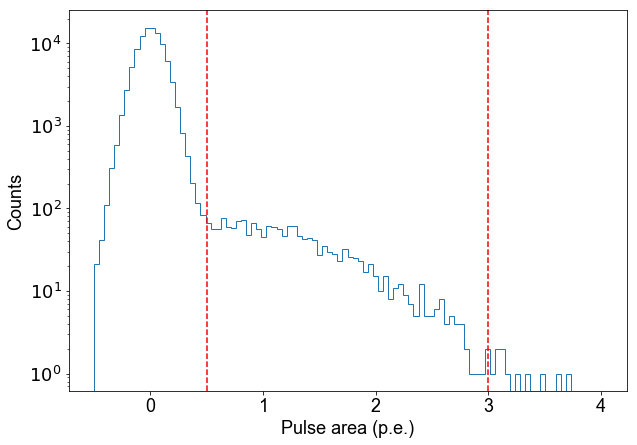

In [108]:
x.plot_area_spectrum(area_bounds = area_cut_bounds, bins=100, histtype='step', range=(-0.5, 4))

In [109]:
x.cut_area(area_cut_bounds)

Selected 1682 of 100000 events (1.68 %)


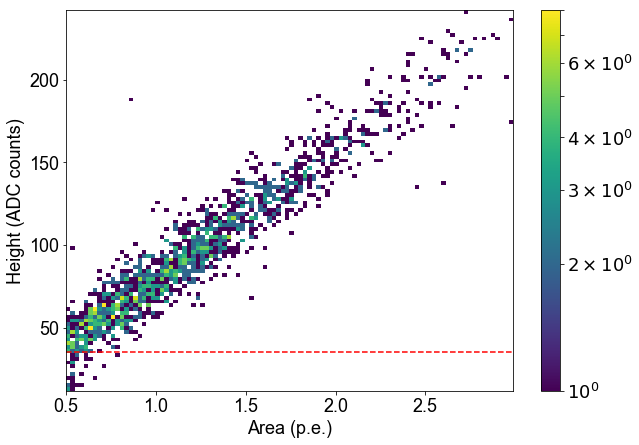

In [110]:
x.plot_area_height(min_amplitude, bins=100, norm=LogNorm())
plt.show()

In [111]:
x.cut_max((min_amplitude, 10000))

Selected 1647 of 1682 events (97.92 %)


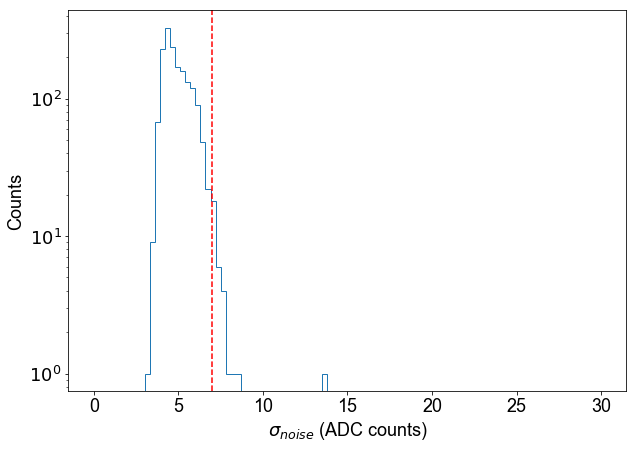

In [112]:
x.plot_noise(noise_max, bins=100, histtype='step', range=(0, 30))
plt.show()

In [113]:
x.cut_noise(noise_max)

Selected 1623 of 1647 events (98.54 %)


In [114]:
x.load_waveforms()
x.process(baseline_left, baseline_right, area_bounds, gain_900_0)

100%|██████████| 100/100 [00:05<00:00, 17.13it/s]


In [115]:
t, pulse = x.get_average_pulse()

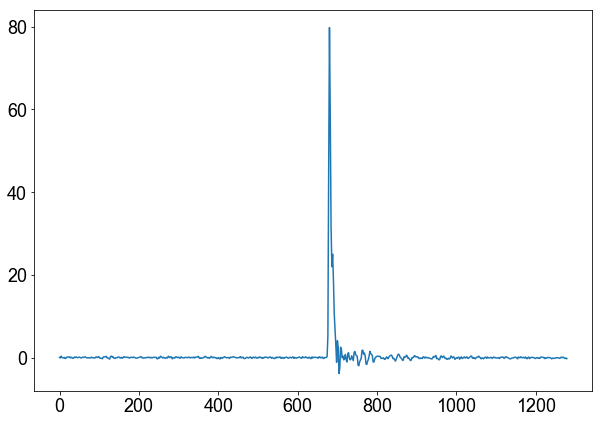

In [116]:
plt.plot(t, pulse)

### Compute average pulse for all datasets and channels

#### Definition of main function

In [118]:
def load_all(dset, channel, gain, area_bounds, area_cut_bounds,
             baseline_left, baseline_right, stop_after = 1000, plot = False):
    x = XAMSRaw('/data/xenon/xams/run8/raw/pmtdata/', dset, channel,
            pickle_dir='/home/erik/win/data/xams_run8/single_e_waveforms/')
    x.process_all(stop_after, baseline_left, baseline_right, area_bounds, gain)
    x.load_processed(stop_after)
    # Cuts
    # Area
    if plot:
        x.plot_area_spectrum(area_bounds = area_cut_bounds, bins=100, histtype='step', range=(-0.5, 4))
        plt.show()
    x.cut_area(area_cut_bounds)
    # Heigth
    if plot:
        x.plot_area_height(min_amplitude, bins=100, norm=LogNorm())
        plt.show()
    x.cut_max((min_amplitude, 10000))
    # Noise
    if plot:
        x.plot_noise(noise_max, bins=100, histtype='step', range=(0, 30))
        plt.show()
    x.cut_noise(noise_max)
    
    # Load waveforms, process, and compute average
    x.load_waveforms()
    x.process(baseline_left, baseline_right, area_bounds, gain)
    t, pulse = x.get_average_pulse()
    
    pickle.dump(pulse, open('%s_ch%d.pickle' % (dset, channel) , 'wb'))
    return x, t, pulse

#### General settings

In [163]:
# All cold datasets, perhaps the last one suffers from Rn? Have to check warm datasets?
datasets = [
  [
    # Ch 0 (900 V)
    # '170313_101924' # warm
    '170313_101924',
    '170323_103732',
    '170327_143657',
    '170404_114542'
  ],
  [
    # Ch 1 (850 V)
    # '170313_102507' # warm
    '170313_102507',
    '170323_104831',
    '170327_144150',
    '170404_115739'
  ]
]

# gain by channel
gains = [2379128.143411107, 2561006.625638467]


In [164]:
# Settings
baseline_left = (275, 325)
baseline_right =(400, 450)
area_bounds = (325, 375)
area_cut_bounds = (0.5, 3)
noise_max = 7
min_amplitude = 35

In [167]:
sure = True

if sure == True:
    for channel in [1]:
        gain = gains[channel]
        for dset in datasets[channel]:
            print(dset)
            _ = load_all(dset, channel, gain, area_bounds, area_cut_bounds,
                 baseline_left, baseline_right, stop_after = 1000, plot = False)


  0%|          | 0/1000 [00:00<?, ?it/s]

170313_102507



100%|██████████| 1000/1000 [00:10<00:00, 98.51it/s]


Selected 50198 of 1000000 events (5.02 %)


  0%|          | 0/1000 [00:00<?, ?it/s]

Selected 49776 of 50198 events (99.16 %)
Selected 48952 of 49776 events (98.34 %)


  0%|          | 0/1000 [00:00<?, ?it/s]

170323_104831


100%|██████████| 1000/1000 [00:17<00:00, 55.63it/s]


Selected 18272 of 1000000 events (1.83 %)
Selected 17270 of 18272 events (94.52 %)
Selected 16906 of 17270 events (97.89 %)


  0%|          | 0/1000 [00:00<?, ?it/s]

170327_144150


100%|██████████| 1000/1000 [00:16<00:00, 59.17it/s]


Selected 18753 of 1000000 events (1.88 %)


  0%|          | 1/1000 [00:00<01:59,  8.37it/s]

Selected 15640 of 18753 events (83.40 %)
Selected 15229 of 15640 events (97.37 %)


  0%|          | 0/1000 [00:00<?, ?it/s]

170404_115739


100%|██████████| 1000/1000 [00:33<00:00, 29.78it/s]


Selected 39091 of 1000000 events (3.91 %)


  0%|          | 0/1000 [00:00<?, ?it/s]

Selected 38527 of 39091 events (98.56 %)
Selected 38348 of 38527 events (99.54 %)


100%|██████████| 1000/1000 [01:07<00:00, 15.04it/s]


### Read all average waveforms and compare

In [126]:
t = np.linspace(0, 639*2, 640)

#### Channel 0

In [168]:
channel = 0

In [169]:
# Read
pulses_ch0 = []
for dset in datasets[channel]:
    pulse = pickle.load(open('%s_ch%d.pickle' % (dset, channel) , 'rb'))
    pulses_ch0.append(pulse)

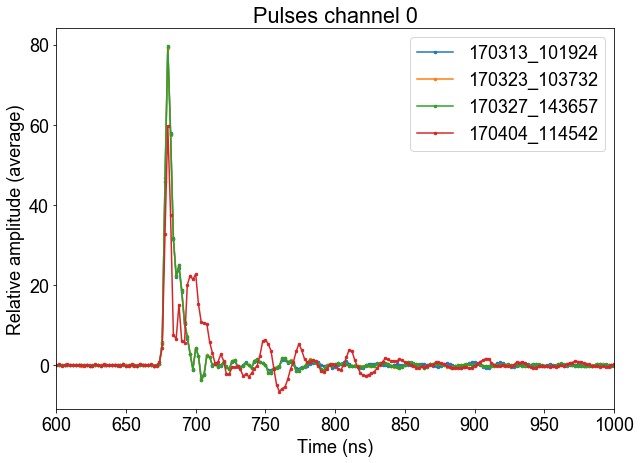

In [170]:
# Plot
for dset, pulse in zip(datasets[channel], pulses_ch0):
    plt.plot(t, pulse, label = dset, marker = '.', markersize = 5)
plt.xlabel('Time (ns)')
plt.ylabel('Relative amplitude (average)')
plt.xlim(600, 1000)
plt.title('Pulses channel %d' % channel)
plt.legend()
plt.show()

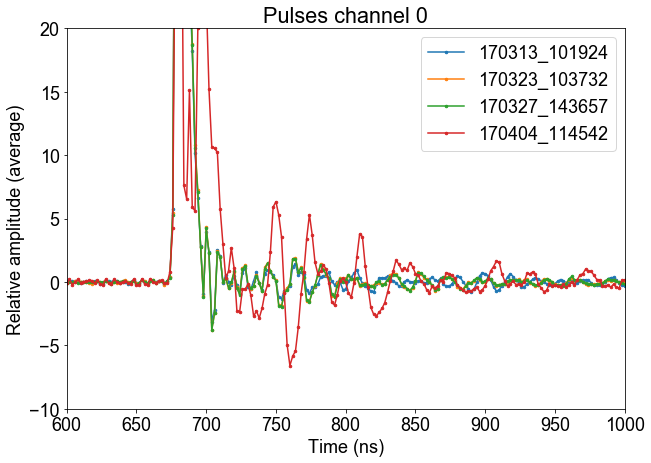

In [171]:
# Plot
for dset, pulse in zip(datasets[channel], pulses_ch0):
    plt.plot(t, pulse, label = dset, marker = '.', markersize = 5)
plt.xlabel('Time (ns)')
plt.ylabel('Relative amplitude (average)')
plt.xlim(600, 1000)
plt.ylim(-10, 20)
plt.title('Pulses channel %d' % channel)
plt.legend()
plt.show()

#### Channel 1

In [172]:
channel = 1

In [173]:
# Read
pulses_ch1 = []
for dset in datasets[channel]:
    pulse = pickle.load(open('%s_ch%d.pickle' % (dset, channel) , 'rb'))
    pulses_ch1.append(pulse)

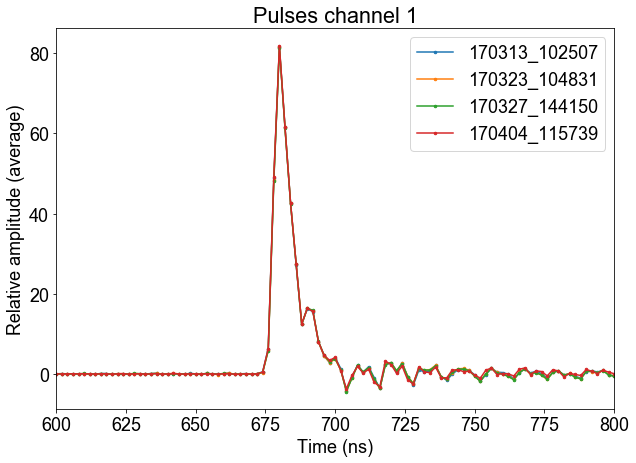

In [174]:
# Plot
for dset, pulse in zip(datasets[channel], pulses_ch1):
    plt.plot(t, pulse, label = dset, marker = '.', markersize = 5)
plt.xlabel('Time (ns)')
plt.ylabel('Relative amplitude (average)')
plt.xlim(600, 800)
plt.title('Pulses channel %d' % channel)
plt.legend()
plt.show()

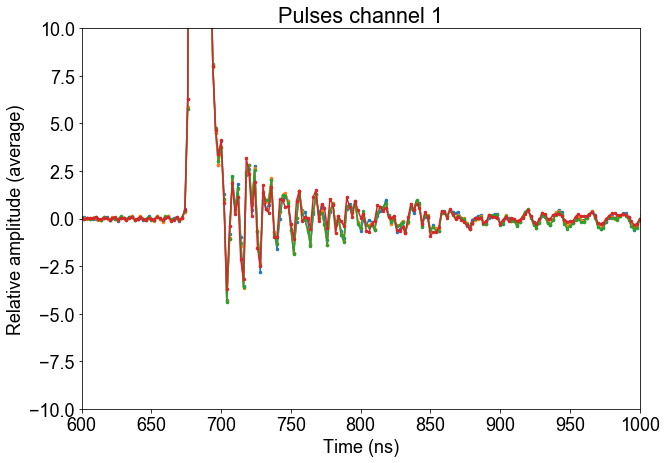

In [175]:
# Plot
for dset, pulse in zip(datasets[channel], pulses_ch1):
    plt.plot(t, pulse, label = dset, marker = '.', markersize = 5)
plt.xlabel('Time (ns)')
plt.ylabel('Relative amplitude (average)')
plt.xlim(600, 1000)
plt.ylim(-10, 10)
plt.title('Pulses channel %d' % channel)
plt.show()

In [149]:
pulse_ch0 = pulses_ch0[1]
pulse_ch1 = pulses_ch1[1]

(600, 800)

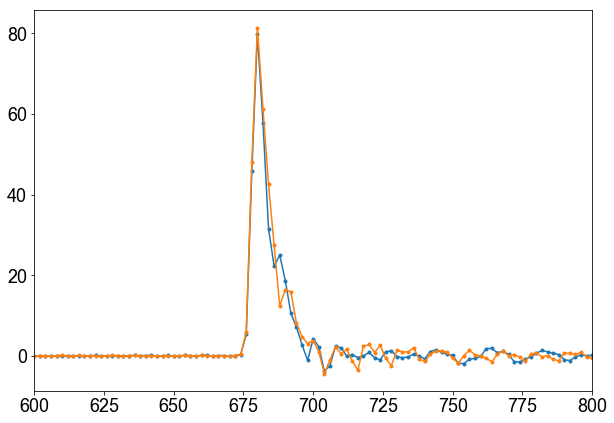

In [150]:
plt.plot(t, pulse_ch0, marker='.')
plt.plot(t, pulse_ch1, marker='.')
plt.xlim(600, 800)

### Area scan

Selected 2876 of 15643 events (18.4 %)
Selected 3270 of 15643 events (20.9 %)
Selected 2970 of 15643 events (19.0 %)
Selected 2348 of 15643 events (15.0 %)
Selected 1668 of 15643 events (10.7 %)
Selected 1142 of 15643 events (7.3 %)
Selected 665 of 15643 events (4.3 %)
Selected 381 of 15643 events (2.4 %)
Selected 210 of 15643 events (1.3 %)
Selected 113 of 15643 events (0.7 %)


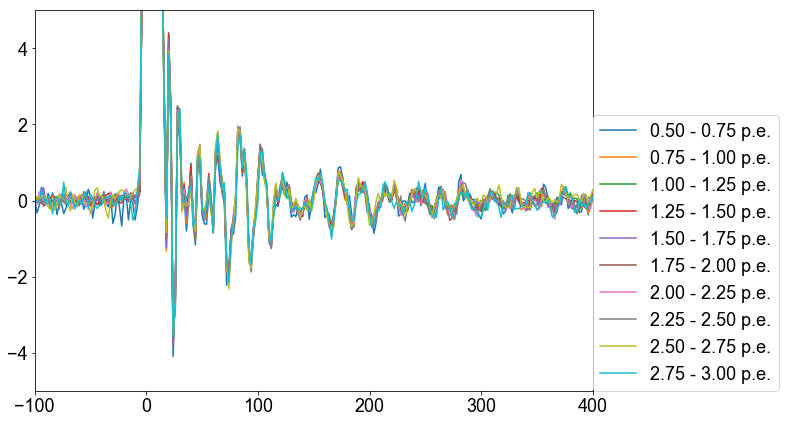

In [26]:
nbins = 11
area_bin_edges = np.linspace(*area_cut_bounds, num=nbins)
for area_min, area_max in zip(area_bin_edges[:-1], area_bin_edges[1:]):
    _x = deepcopy(x)
    _x.cut_area(channel, (area_min, area_max))
    _time, _pulse = _x.get_average_pulse(0, normalize=True, align_on='max_index', alignment_bin=340)
    plt.plot(_time - 340 * 2, _pulse, label='%.2f - %.2f p.e.' % (area_min, area_max))
plt.legend(loc=(1,0))
plt.xlim(-100, 400)
plt.ylim(-5, 5)
plt.show()

### Channel 1 (PMT1)

### To check out:

  * Per dataset
  * For different area slices (Looks good!)
  * Jackknife?
  * FFT

In [153]:
from IPython.display import display, Javascript
display(Javascript("""
require(
    ["base/js/dialog"], 
    function(dialog) {
        dialog.modal({
            title: 'Hello world',
            body: 'Hi, lorem ipsum and such',
            buttons: {
                'kthxbye': {}
            }
        });
    }
);
"""))

<IPython.core.display.Javascript object>